In [1]:
! git clone https://github.com/seejiafong/video_features.git
! pip install omegaconf==2.0.6

Cloning into 'video_features'...
remote: Enumerating objects: 1213, done.
remote: Counting objects: 100% (346/346), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 1213 (delta 237), reused 263 (delta 194), pack-reused 867
Receiving objects: 100% (1213/1213), 288.05 MiB | 20.41 MiB/s, done.
Resolving deltas: 100% (650/650), done.
Updating files: 100% (177/177), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%cd video_features
from models.i3d.extract_i3d import ExtractI3D
from utils.utils import build_cfg_path
from omegaconf import OmegaConf
import torch
import numpy as np
import glob
import pickle
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger, EarlyStopping
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import os
import random as random
import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device ', device)

/content/video_features
device  cuda


In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#global variables
step=8
stack=12
num_frames_per_video=96
num_windows = (96-stack)/step
folderpath      = '/content/gdrive/My Drive/iss/itsspm/i3d/modelcheckpoints/' #for callbacks
data_dir = "/content/gdrive/My Drive/iss/itsspm/i3d/96Frames/"
X_train = []
X_test = []
y_train = [] 
y_test = []

In [5]:
def extractI3D(folder_paths):
  # Load and patch the config
  args = OmegaConf.load(build_cfg_path('i3d'))
  args.stack_size = stack
  args.step_size = step 
  #args.extraction_fps = 25 # default = 25, no need to define if it is 25, 
                            # as definining this will create a new video 
                            # before processing
  args.streams = 'rgb'
  #args.device = 'cpu' #uncomment if on cpu

  # Load the model
  extractor = ExtractI3D(args)

  for path in folder_paths:
    count = 1
    for video_path in glob.glob(path):
        vidname = video_path.replace('.mp4','')
        if (not os.path.exists(vidname+'_rgb.npy')): #in case you decide to stop halfway
                                                    # rerunning the code will not re-extract
                                                    # the ones you extracted previously
          print(f'{count} : Extracting for {video_path}')
          feature_dict = extractor.extract(video_path)
          
          for k, v in feature_dict.items():
            if (k=='rgb'):
              outfile = vidname+'_'+k+'.npy'
              v=v.reshape(1,int(num_windows*1024))
              np.save(outfile, v)
              count = count + 1
        else:
          print(f'{count} : NPY exists, skipping for {video_path}')
          count = count + 1


# Extract features
folder_paths = [data_dir+"test/*.mp4", 
                  data_dir+"train/*.mp4"]
extractI3D(folder_paths)

1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/96Frames/test/FINADivingWorldCup2021_Men3m_final_r1_0_all.mp4
1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/96Frames/test/05_61_all.mp4
1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/96Frames/test/01_124_all.mp4
1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/96Frames/test/09_69_all.mp4
1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/96Frames/test/22_14_all.mp4
1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/96Frames/test/14_40_all.mp4
1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/96Frames/test/10_41_all.mp4
1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/96Frames/test/07_17_all.mp4
1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/96Frames/test/01_140_all.mp4
1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/96Frames/test/07_18_all.mp4
1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/96Frames/test/FINADivingWorldCup202

In [ ]:
def getNumpyArray(key):
    videoName = key + "_all_rgb.npy"
    features = np.array([])
    if (os.path.isfile(data_dir + 'train/'+ videoName)): 
        features = np.load(data_dir + 'train/'+ videoName)
    elif (os.path.isfile(data_dir + 'test/'+ videoName)): 
        features = np.load(data_dir + 'test/'+ videoName)
    return features

def loadDataFromCsv(filename):
    X = []
    y = []
    scaler = MinMaxScaler()
    
    with open(filename, 'r') as dat:
        lines = dat.readlines()
        count_processed = 0
        for i in range(len(lines)):
            if i > 0: # i==0 is headerline
                line = lines[i]
                tokens = line.split(',')
                if (len(tokens[0]) > 0 and len(tokens[3]) > 0): # tokens[0] is the filename and tokens[3] is the dive score
                    keytokens = tokens[0].split('/')
                    Xdata = getNumpyArray(keytokens[1] +"_"+keytokens[2])
                    if (Xdata.shape==(1, num_windows*1024)):
                        X.append(Xdata.reshape(int(num_windows*1024)))
                        divescore = float(tokens[3])
                        y.append(divescore)
                        count_processed+=1
    X = np.array(X)
    y = scaler.fit_transform(np.array(y).reshape(count_processed,1)).reshape(count_processed,)
    return X, y

def loadData():
    global X_train, X_test, y_train, y_test
    X_train, y_train = loadDataFromCsv(data_dir+'train.csv')
    X_test, y_test= loadDataFromCsv(data_dir+'test.csv')
    
    print('training samples : ', len(X_train))
    print('testing samples : ', len(X_test))

In [ ]:
def createModel(modelname, learning_rate):
    opt = optimizers.SGD(learning_rate=learning_rate)
    model = keras.Sequential()
    model.add(keras.layers.Input(int(num_windows*1024)))
    model.add(keras.layers.Dense(256))
    model.add(keras.layers.Dense(48))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer=opt)
    model.summary()
    return model

def createCallbacks(modelname):
    csv_logger      = CSVLogger(folderpath+modelname +'.csv')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    callbacks_list  = [csv_logger, es]
    
    print("Callbacks created:")
    print(callbacks_list[0])
    print(callbacks_list[1])
    print('')
    print("Path to log:  ", folderpath+modelname+'.csv')
    return callbacks_list

In [ ]:
def trainModel(modelname, model):
    #reset all the random seeds so that the training result is replicable
    random.seed(1)
    np.random.seed(1)
    tf.random.set_seed(1)

    callbacks_list = createCallbacks(modelname)
    history = model.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=500,
        shuffle=True,
        validation_data=(X_test, y_test),
        callbacks=callbacks_list
    )


In [ ]:
def showResult(modelname):
    records = pd.read_csv(folderpath+modelname +'.csv')
    plt.figure(figsize=(6,4))
    plt.plot(records['val_loss'], label="validation")
    plt.plot(records['loss'],label="training")
    minY = min(min(records['val_loss']), min(records['loss']))
    maxY = max(max(records['val_loss']), max(records['loss']))
    stepY = (maxY-minY)/10
    plt.yticks(np.arange(minY, maxY, stepY))
    plt.title(modelname+ ' MSE Loss',fontsize=12)

    ax = plt.gca()
    minX = min(records['epoch'])
    maxX = max(records['epoch'])
    stepX = int((maxX-minX)/10)
    
    plt.xticks(np.arange(minX, maxX, stepX))
    plt.savefig(folderpath+modelname+".jpg")
    plt.show()
    ax.legend()
    
    

In [ ]:
def validation_results(modelname, model):
    actual_scores = []
    predicted_scores = []
    
    with open(folderpath+modelname+'valresult.csv', 'w') as csvfile: 
        csvwriter = csv.writer(csvfile) 
        csvwriter.writerow(['file', 'actualscore', 'predscore'])
        for i in range(len(X_test)):
            vidScore = y_test[i]
            actual_scores.append(vidScore)
            vidFeatures = X_test[i]
            prediction = model.predict(vidFeatures.reshape(1,int(num_windows*1024)))
            predicted_scores.append(prediction[0][0])
            csvwriter.writerow([str(i), str(vidScore), str(prediction[0][0])])
            print (str(i)+ ' : actual ' + str(vidScore) + ' predicted ' + str(prediction[0][0]))
    with open(folderpath+'log.csv', 'a') as csvfile2:
        csvwriter = csv.writer(csvfile2) 
        coef, p = spearmanr(actual_scores, predicted_scores)
        print('Spearmans correlation coefficient: %.3f' % coef)
        # interpret the significance
        alpha = 0.05
        correlated = 'Correlated'
        if p > alpha:
            correlated = 'Uncorrelated'
            print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
        else:
            correlated = 'Correlated'
            print('Samples are correlated (reject H0) p=%.3f' % p)
        csvwriter.writerow([modelname, str(coef), str(p), correlated])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               5505280   
                                                                 
 dense_10 (Dense)            (None, 48)                12336     
                                                                 
 dense_11 (Dense)            (None, 1)                 49        
                                                                 
Total params: 5,517,665
Trainable params: 5,517,665
Non-trainable params: 0
_________________________________________________________________
Callbacks created:

Path to log:   /content/gdrive/My Drive/iss/itsspm/i3d/modelcheckpoints/diving_score_regressor_0.01.csv
Epoch 1/500
14/14 [==============================] - 1s 28ms/step - loss: 0.1571 - val_loss: 0.2501
Epoch 2/500
14/14 [==============================] - 0s 13ms/step - loss: 0.1827 - v

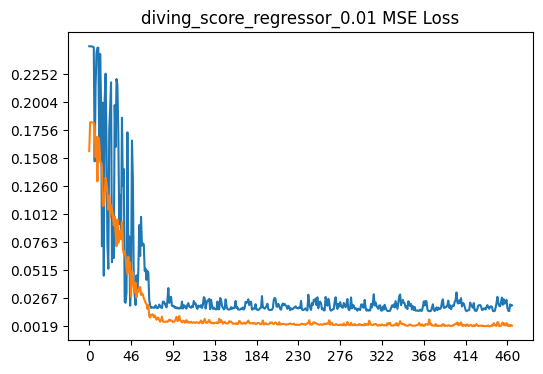

1/1 [==============================] - 0s 47ms/step
0 : actual 0.5842293906810037 predicted 0.5155428
1/1 [==============================] - 0s 18ms/step
1 : actual 0.6594982078853047 predicted 0.70058066
1/1 [==============================] - 0s 17ms/step
2 : actual 0.6021505376344087 predicted 0.68538904
1/1 [==============================] - 0s 18ms/step
3 : actual 0.3333333333333334 predicted 0.24657483
1/1 [==============================] - 0s 17ms/step
4 : actual 0.35842293906810047 predicted 0.5462385
1/1 [==============================] - 0s 19ms/step
5 : actual 0.6403823178016728 predicted 0.47558877
1/1 [==============================] - 0s 22ms/step
6 : actual 0.36559139784946243 predicted 0.49895915
1/1 [==============================] - 0s 30ms/step
7 : actual 0.26762246117084837 predicted 0.44478992
1/1 [==============================] - 0s 22ms/step
8 : actual 0.3225806451612904 predicted 0.4728367
1/1 [==============================] - 0s 18ms/step
9 : actual 0.18279569

In [ ]:
def main():
    loadData()
    learning_rate=0.01
    modelname = "diving_score_regressor_"+str(learning_rate)
    model = createModel(modelname, learning_rate)
    trainModel(modelname, model)
    model.save(folderpath+modelname+".h5")
    showResult(modelname)
    validation_results(modelname, model)

main()

In [ ]:
def normalizeToFrames(vidpath, targetNumOfFrames):
  video_reader = cv2.VideoCapture(vidpath)
  index={}
  files=[]
  while True: 
      status, frame = video_reader.read() 
      if not status:
          break      
      files.append(frame)
      index[len(files)-1]=1
  video_reader.release()
  if (len(files) < targetNumOfFrames):
      diff = targetNumOfFrames - len(files)
      count_diff = 0;
      while (count_diff < diff):
          rand = random.choice(range(len(files)))
          index[rand] = index[rand]+1
          count_diff += 1
      
  elif (len(files) > targetNumOfFrames):
      diff = len(files) - targetNumOfFrames
      count_diff = 0;
      while (count_diff < diff):
          rand = random.choice(range(len(files)))
          if (index[rand] > 0):
              index[rand] = index[rand]-1
              count_diff += 1
  sortedkeys = list(index.keys())
  sortedkeys.sort()

  height, width, layers = files[0].shape
  extensionSep = vidpath.rindex(".")
  filenameSep = vidpath.rindex("/")
  vidname = vidpath[filenameSep+1:extensionSep]
  vidFullName = folderpath+vidname+"N.mp4"
  fps = 25
  video_writer = cv2.VideoWriter(vidFullName, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), fps, (width,height))
  for key in sortedkeys:
      frame = files[key]
      for i in range(index[key]):
          video_writer.write(frame)

  video_writer.release()
  return vidFullName


def predict(vidpath):
  model = load_model(folderpath+'diving_score_regressor_0.01.h5')
  vidpath_norm = normalizeToFrames(vidpath, num_frames_per_video)
  extractI3D([vidpath_norm])
  npyFile = vidpath_norm.replace('.mp4','_rgb.npy')
  features = np.load(npyFile)
  prediction = model.predict(features.reshape(1,int(num_windows*1024)))
  print(vidpath, '... predicted score : ', prediction[0][0])

#query videos from UNLV diving dataset
''' Ground truth scores (video, score)
93,37.4
117,55.8
153,64.35
99,75.2
100,85.8
107,94.05
'''
predict(data_dir+"query/093.mp4")
predict(data_dir+"query/117.mp4")
predict(data_dir+"query/153.mp4")
predict(data_dir+"query/099.mp4")
predict(data_dir+"query/100.mp4")
predict(data_dir+"query/107.mp4")

1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/modelcheckpoints/093N.mp4
1/1 [==============================] - 0s 46ms/step
/content/gdrive/My Drive/iss/itsspm/i3d/96Frames/query/093.mp4 ... predicted score :  0.34060562
1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/modelcheckpoints/117N.mp4
1/1 [==============================] - 0s 56ms/step
/content/gdrive/My Drive/iss/itsspm/i3d/96Frames/query/117.mp4 ... predicted score :  0.5250838
1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/modelcheckpoints/153N.mp4
1/1 [==============================] - 0s 59ms/step
/content/gdrive/My Drive/iss/itsspm/i3d/96Frames/query/153.mp4 ... predicted score :  0.60971
1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/modelcheckpoints/099N.mp4
1/1 [==============================] - 0s 69ms/step
/content/gdrive/My Drive/iss/itsspm/i3d/96Frames/query/099.mp4 ... predicted score :  0.6463906
1 : Extracting for /content/gdrive/My Drive/iss/itsspm/i3d/modelcheck